In [9]:
import datetime as dt
import os
import sys

import numpy as np
import pandas as pd
from scipy import interp
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, auc, confusion_matrix, roc_curve, average_precision_score, precision_recall_curve
from sklearn.model_selection import StratifiedKFold
import sqlalchemy as sa
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../')
from utilities import sql_utils as su
from utilities import model_eval_utils as meu

DWH = os.getenv('CD_DWH')
engine = create_engine(DWH)

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [10]:
QUERY = su.get_sql_as_string('../notebooks/sql/campaign_finance_and_election_results')
with engine.begin() as conn:
    df = pd.read_sql(QUERY, conn)
    df.set_index('candidate_name', inplace=True)

## Exploring the Data

In [14]:
df

,total_transaction,is_winner
candidate_name,,
robbonta,1876284.190,1
gwenlmorris,62408.320,0
tonythurmond,1247488.450,1
evanlow,1185313.920,1
danteacosta,987814.080,1
cherylcookkallio,3064946.900,0
ricardolara,1437865.270,1
clintolivier,736238.920,0
christysmith,1800899.510,0


## Machine Learning

In [15]:
def split_dataset(dataset, train_percentage, feature_headers, target_header):
    """
    Split the dataset with train_percentage
    
    Keyword Args:
    dataset: The Actual Dataset
    train_percentage: Percentage of Dataset to split into Training
    feature_headers: columns that are features to include
    target_header: column that is the outcome variable of interest
    :return: train_x, test_x, train_y, test_y
    """

    # Split dataset into train and test dataset
    train_x, test_x, train_y, test_y = train_test_split(dataset[feature_headers], dataset[target_header],
                                                        train_size=train_percentage)
    return train_x, test_x, train_y, test_y

In [16]:
target_header = 'is_winner'
feature_headers = list(set(df.columns) - set([target_header]))
X = df.loc[:,df.columns != 'is_winner']
y = df.is_winner
train_x, test_x, train_y, test_y = split_dataset(df, 0.7, feature_headers, target_header)

/Users/lauramcrae/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [17]:
# Train and Test dataset size details
print("Train_x Shape :: ", train_x.shape)
print("Train_y Shape :: ", train_y.shape)
print("Test_x Shape :: ", test_x.shape)
print("Test_y Shape :: ", test_y.shape)

Train_x Shape ::  (81, 1)
Train_y Shape ::  (81,)
Test_x Shape ::  (35, 1)
Test_y Shape ::  (35,)


In [18]:
df.columns

Index(['total_transaction', 'is_winner'], dtype='object')

## Support Vector Classification
Used GridSearch CV (not shown) to find the shown parameters. Added 3rd degree polynomial features to our numeric data and also used standard scaling.
This ROC curve was not as smooth as the Random Forest, but that is not necessarily a bad thing.

In [19]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
#param_grid = [
#  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
#  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
# ]
#cv_svm = StratifiedKFold(n_splits=6)
#clf = GridSearchCV(SVC(), tuned_parameters, cv=cv_svm, n_jobs=3)
#clf.fit(train_x,train_y)

#print("Best parameters set found on development set:")
#print()
#print(clf.best_params_)

In [20]:
#cv_svm = StratifiedKFold(n_splits=6)
#grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv_svm)
#grid.fit(X, y)

#print("The best parameters are %s with a score of %0.2f"
#      % (grid.best_params_, grid.best_score_))

In [21]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
rbf_kernel_svm_clf = Pipeline((
 ("poly_features", PolynomialFeatures(degree=3)),   
 ("scaler", StandardScaler()),
 ("svm_clf", SVC(C=1, gamma=1.0000000000000001e-09, probability=True))
 ))
trained_svm = rbf_kernel_svm_clf.fit(train_x, train_y)
 #Evaluation

In [22]:
cv_svm = StratifiedKFold(n_splits=6)

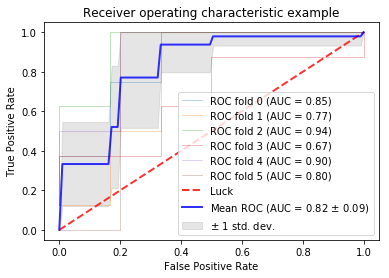

In [23]:
meu.draw_cv_roc_curve(trained_svm, cv_svm, train_x, train_y)

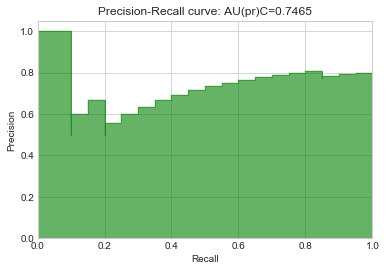

In [24]:
meu.plot_precision_recall_curve(trained_svm, test_x, test_y)

## Soft Voting Classifier
Used the Random forest Vince was working on in combination with my SVC and a simple logistic regression model to see if the combination of these models would perform better. The accuracy seems to go down in combination with the logistic and eachother as well.

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
rbf_kernel_svm_clf = Pipeline((
 ("poly_features", PolynomialFeatures(degree=3)),   
 ("scaler", StandardScaler()),
 ("svm_clf", SVC(C=1, gamma=1.0000000000000001e-09, probability=True))
 ))
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', rbf_kernel_svm_clf)], voting='soft')
voting_clf.fit(train_x, train_y)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomF...  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)))))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

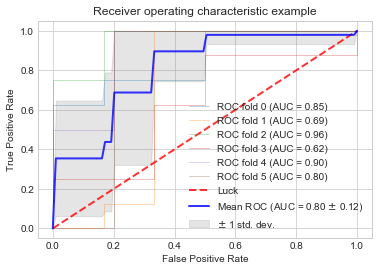

In [26]:
cv_svm = StratifiedKFold(n_splits=6)
meu.draw_cv_roc_curve(voting_clf, cv_svm, train_x, train_y)

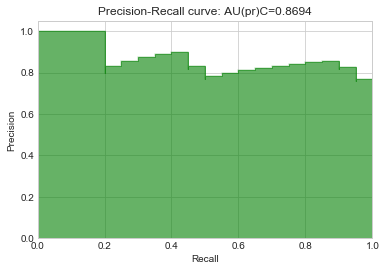

In [27]:
meu.plot_precision_recall_curve(voting_clf, test_x, test_y)

## Adaboost DecisionTree Classifier
I wanted to test out if an ensamble method would work well with the given data. Used a decision tree classifier to mix things up a little. Did not work out as well as other methods.

In [28]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_clf = AdaBoostClassifier(
 DecisionTreeClassifier(max_depth=1),
 algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(train_x, train_y)


AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=50, random_state=None)

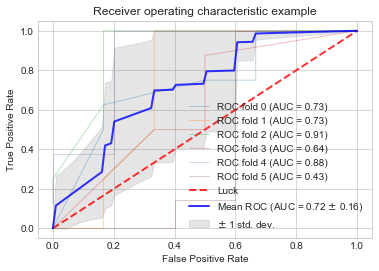

In [29]:
cv_svm = StratifiedKFold(n_splits=6)
meu.draw_cv_roc_curve(ada_clf, cv_svm, train_x, train_y)

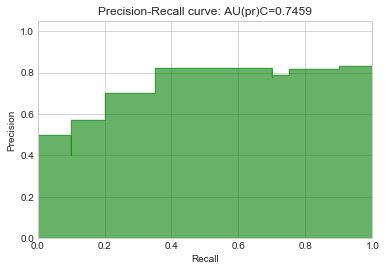

In [30]:
meu.plot_precision_recall_curve(ada_clf, test_x, test_y)

## Build a Random Forest Classifier

In [17]:
clf = RandomForestClassifier()
trained_model = clf.fit(train_x, train_y)

### Evaluation

In [18]:
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)

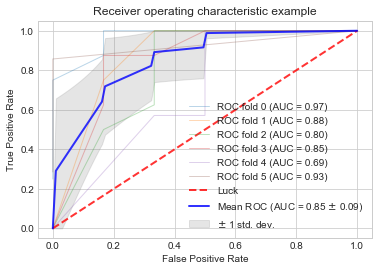

In [19]:
# Creating ROC Curve with Cross Validation
meu.draw_cv_roc_curve(clf, cv, train_x, train_y)

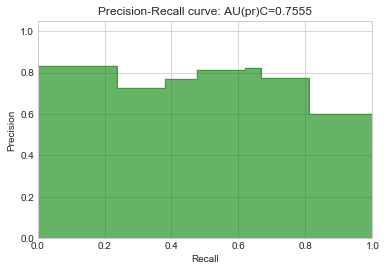

In [20]:
# Plotting Precision Recall Curve
meu.plot_precision_recall_curve(clf, test_x, test_y)

In [26]:
predictions = trained_model.predict(test_x)

In [ ]:
# Train and Test Accuracy
print("Train Accuracy :: ", accuracy_score(train_y, trained_model.predict(train_x)))
print("Test Accuracy  :: ", accuracy_score(test_y, predictions))
print(" Confusion matrix ", confusion_matrix(test_y, predictions))

In [ ]:
meu.show_confusion_matrix(confusion_matrix(test_y, predictions))

### Extracting Important Features

In [ ]:
importances = trained_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in trained_model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

#for f in range(train_x.shape[1]):
for f in range(25): 
    column = train_x.columns[indices[f]]
    print("{ranking}. feature {column} ({importance})".format(ranking=f+1,
                                                             column=column,
                                                             importance=importances[indices[f]]))

In [ ]:
# Plot the feature importances of the forest
top_features = 10
plt.figure(figsize=(20, 10))
plt.title("Feature importances")
plt.bar(range(top_features),
        importances[indices[0:top_features]],
        color="r",
        yerr=std[indices[0:top_features]],
        align="center")
plt.xticks(range(top_features), train_x.columns[indices[0:top_features]])
plt.xlim([-1, top_features])
plt.show()